
====== UPLOAD CSV for GLO (e.g., stock_data_GLO.csv) ======


Saving stock_data_GLO.csv to stock_data_GLO (1).csv

--- GLO Stock Data Statistics ---
             Close
count   245.000000
mean   2005.640816
std     224.741932
min    1700.000000
25%    1754.000000
50%    2060.000000
75%    2178.000000
max    2460.000000


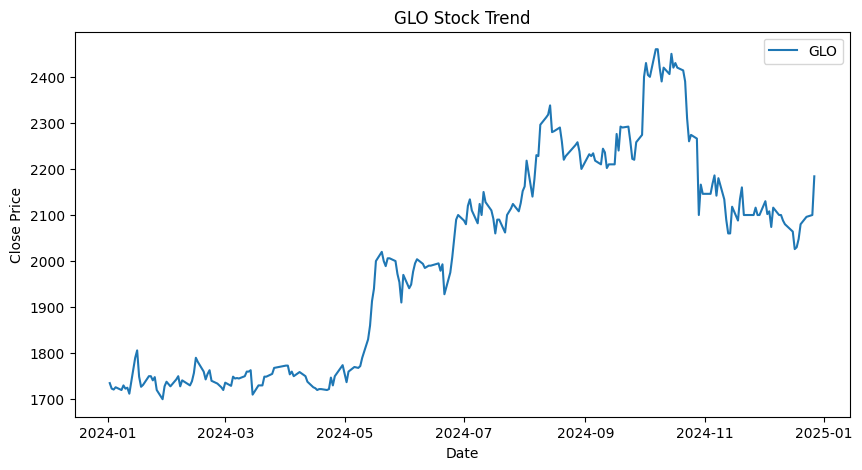


--- GLO Daily Returns (First 10 values) ---
Date
2024-12-26   -0.038462
2024-12-23   -0.001905
2024-12-20   -0.007634
2024-12-19   -0.015385
2024-12-18   -0.008789
2024-12-17   -0.001970
2024-12-16    0.018756
2024-12-13    0.005814
2024-12-12    0.001927
2024-12-11    0.003846
Name: Close, dtype: float64


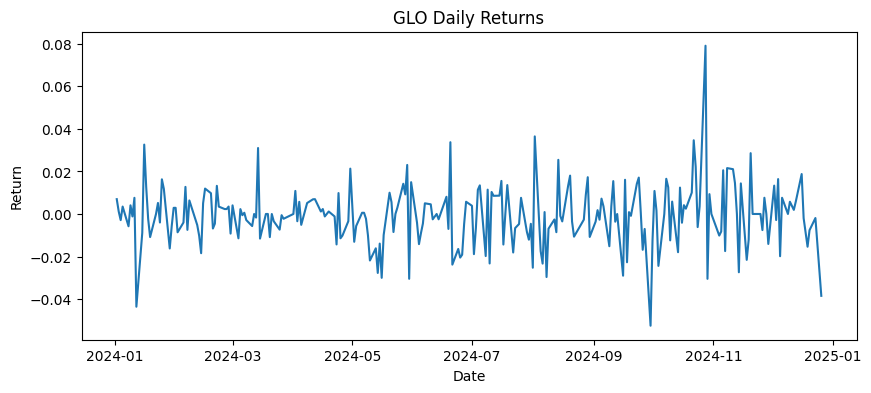


(GLO) Forecasted 1-day volatility: 0.011146

--- Hybrid Monte Carlo + GARCH VaR for GLO ---
  Confidence Level GLO 1-Day VaR (PHP) GLO 10-Day VaR (PHP)  \
0              90%         -15,090,488          -53,474,873   
1              95%         -19,186,573          -66,626,013   
2              99%         -26,896,122          -90,739,553   

  GLO Annual VaR (PHP)  
0         -438,413,801  
1         -503,369,645  
2         -626,969,113  


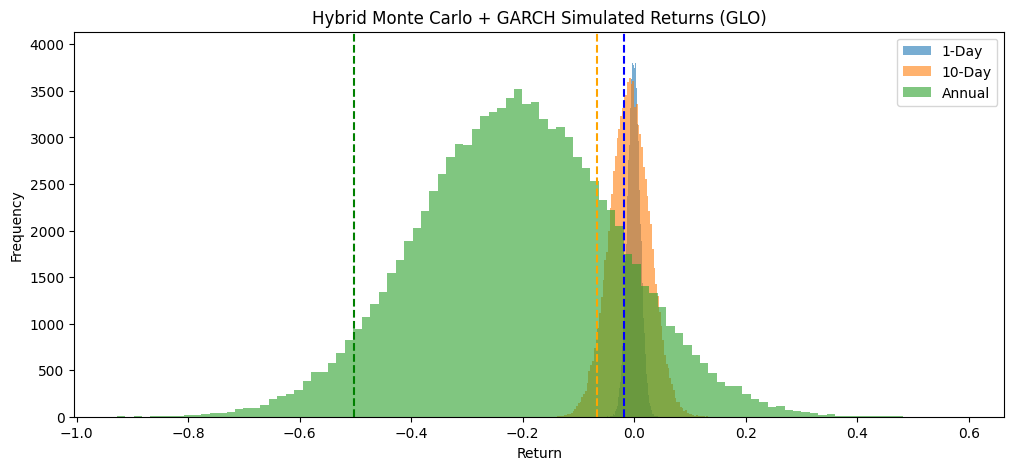


====== UPLOAD CSV for TEL (e.g., stock_data_TEL.csv) ======


Saving stock_data_TEL.csv to stock_data_TEL (1).csv

--- TEL Stock Data Statistics ---
             Close
count   245.000000
mean   1396.869388
std      94.049076
min    1252.000000
25%    1300.000000
50%    1399.000000
75%    1476.000000
max    1608.000000


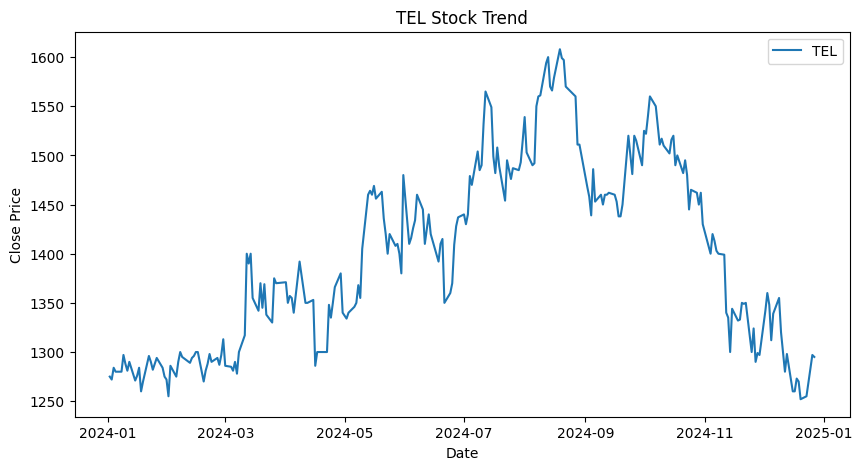


--- TEL Daily Returns (First 10 values) ---
Date
2024-12-26    0.001544
2024-12-23   -0.032382
2024-12-20   -0.002390
2024-12-19    0.014377
2024-12-18    0.002362
2024-12-17   -0.010212
2024-12-16    0.000000
2024-12-13    0.030159
2024-12-12   -0.013867
2024-12-11    0.015625
Name: Close, dtype: float64


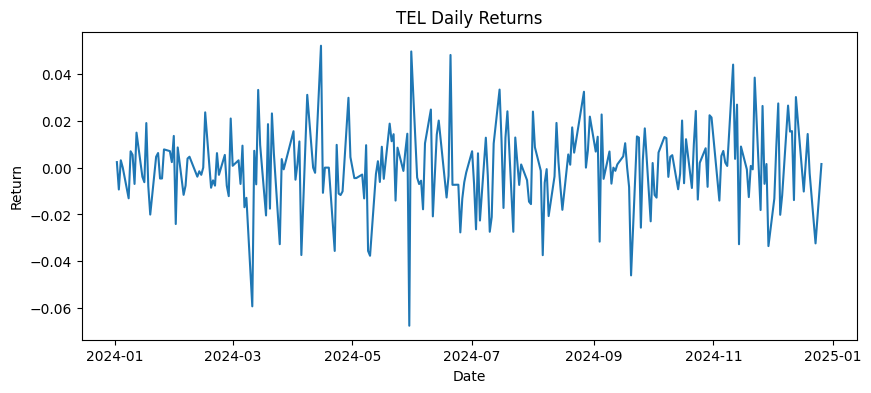


(TEL) Forecasted 1-day volatility: 0.014504

--- Hybrid Monte Carlo + GARCH VaR for TEL ---
  Confidence Level TEL 1-Day VaR (PHP) TEL 10-Day VaR (PHP)  \
0              90%         -18,398,151          -58,269,171   
1              95%         -23,724,302          -75,250,684   
2              99%         -33,851,538         -106,584,007   

  TEL Annual VaR (PHP)  
0         -274,603,707  
1         -357,574,330  
2         -514,970,681  


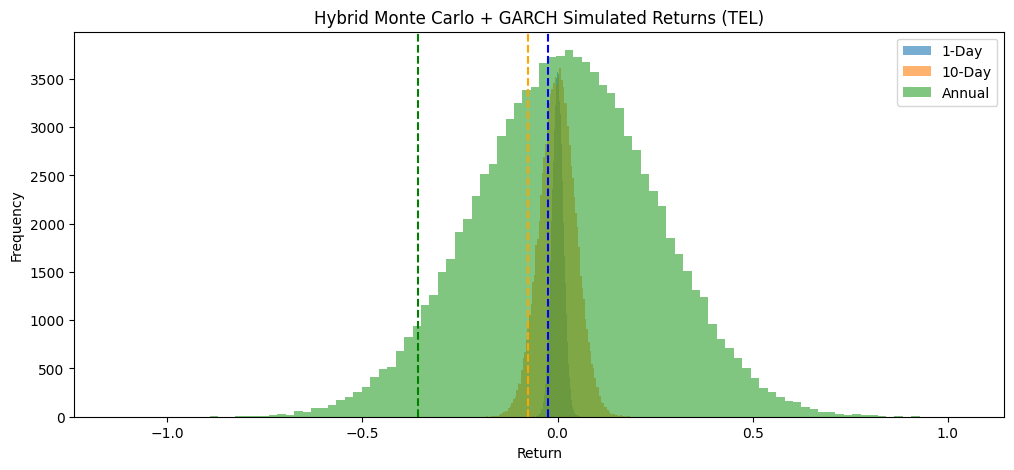



================== FINAL OUTPUT TABLES ==================

>>> GLO VaR Table:
  Confidence Level GLO 1-Day VaR (PHP) GLO 10-Day VaR (PHP)  \
0              90%         -15,090,488          -53,474,873   
1              95%         -19,186,573          -66,626,013   
2              99%         -26,896,122          -90,739,553   

  GLO Annual VaR (PHP)  
0         -438,413,801  
1         -503,369,645  
2         -626,969,113  

>>> TEL VaR Table:
  Confidence Level TEL 1-Day VaR (PHP) TEL 10-Day VaR (PHP)  \
0              90%         -18,398,151          -58,269,171   
1              95%         -23,724,302          -75,250,684   
2              99%         -33,851,538         -106,584,007   

  TEL Annual VaR (PHP)  
0         -274,603,707  
1         -357,574,330  
2         -514,970,681  


In [2]:
# ============================================================
# GLO + TEL STOCK ANALYSIS + HYBRID Monte Carlo + GARCH VaR
# ============================================================

!pip install arch --quiet

# -------------------- IMPORT LIBRARIES ---------------------
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from google.colab import files

# -------------------- PARAMETERS ---------------------------
PortfolioValue = 1_000_000_000  # 1 billion PHP
ConfidenceLevels = [0.90, 0.95, 0.99]
NumSimulations = 100_000
TradingDaysYear = 252
TradingDays10 = 10


# -----------------------------------------------------------
# FUNCTION: PROCESS STOCK (CSV upload → clean → analyze)
# -----------------------------------------------------------
def process_stock(stock_name):

    print(f"\n====== UPLOAD CSV for {stock_name} (e.g., stock_data_{stock_name}.csv) ======")
    uploaded = files.upload()

    # READ & CLEAN
    for fn in uploaded.keys():
        df = pd.read_csv(fn)
        df["Close"] = pd.to_numeric(df["Close"].astype(str).str.replace(",", ""), errors="coerce")
        df = df[["Date","Close"]].dropna()

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df.set_index("Date", inplace=True)

    print(f"\n--- {stock_name} Stock Data Statistics ---")
    print(df.describe())

    # PRICE TREND
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df["Close"], label=stock_name)
    plt.title(f"{stock_name} Stock Trend")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

    # RETURNS
    returns = df["Close"].pct_change().dropna()

    print(f"\n--- {stock_name} Daily Returns (First 10 values) ---")
    print(returns.head(10))

    plt.figure(figsize=(10,4))
    plt.plot(returns.index, returns, label=f"{stock_name} Returns")
    plt.title(f"{stock_name} Daily Returns")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.show()

    # GARCH(1,1)
    r_scaled = returns * 100
    garch = arch_model(r_scaled, vol="Garch", p=1, q=1, dist="normal")
    fit = garch.fit(disp="off")

    forecast = fit.forecast(horizon=1)
    sigma_1d = np.sqrt(forecast.variance.values[-1, 0]) / 100
    mu = r_scaled.mean() / 100

    print(f"\n({stock_name}) Forecasted 1-day volatility: {sigma_1d:.6f}")

    # Monte Carlo Simulation
    shocks_1d = np.random.normal(0, sigma_1d, NumSimulations)
    sim_returns_1d = mu + shocks_1d

    sigma_10d = sigma_1d * np.sqrt(TradingDays10)
    sigma_annual = sigma_1d * np.sqrt(TradingDaysYear)

    sim_returns_10d = mu*TradingDays10 + np.random.normal(0, sigma_10d, NumSimulations)
    sim_returns_annual = mu*TradingDaysYear + np.random.normal(0, sigma_annual, NumSimulations)

    # VaR TABLE
    VaR_table = []
    for conf in ConfidenceLevels:
        VaR_1 = PortfolioValue * np.percentile(sim_returns_1d, 100*(1 - conf))
        VaR_10 = PortfolioValue * np.percentile(sim_returns_10d, 100*(1 - conf))
        VaR_ann = PortfolioValue * np.percentile(sim_returns_annual, 100*(1 - conf))

        VaR_table.append({
            "Confidence Level": f"{int(conf*100)}%",
            f"{stock_name} 1-Day VaR (PHP)": f"{VaR_1:,.0f}",
            f"{stock_name} 10-Day VaR (PHP)": f"{VaR_10:,.0f}",
            f"{stock_name} Annual VaR (PHP)": f"{VaR_ann:,.0f}"
        })

    VaR_df = pd.DataFrame(VaR_table)
    print(f"\n--- Hybrid Monte Carlo + GARCH VaR for {stock_name} ---")
    print(VaR_df)

    # HISTOGRAM PLOT
    plt.figure(figsize=(12,5))
    plt.hist(sim_returns_1d, bins=100, alpha=0.6, label='1-Day')
    plt.hist(sim_returns_10d, bins=100, alpha=0.6, label='10-Day')
    plt.hist(sim_returns_annual, bins=100, alpha=0.6, label='Annual')

    plt.axvline(np.percentile(sim_returns_1d, 5), color='blue', linestyle='dashed')
    plt.axvline(np.percentile(sim_returns_10d, 5), color='orange', linestyle='dashed')
    plt.axvline(np.percentile(sim_returns_annual, 5), color='green', linestyle='dashed')

    plt.title(f"Hybrid Monte Carlo + GARCH Simulated Returns ({stock_name})")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return df, returns, VaR_df


# -----------------------------------------------------------
#  RUN ANALYSIS FOR BOTH GLO AND TEL
# -----------------------------------------------------------

GLOData, GLOReturns, GLO_VaR = process_stock("GLO")
TELData, TELReturns, TEL_VaR = process_stock("TEL")

print("\n\n================== FINAL OUTPUT TABLES ==================")
print("\n>>> GLO VaR Table:")
print(GLO_VaR)

print("\n>>> TEL VaR Table:")
print(TEL_VaR)
